In [115]:
#Defining some Classic Variables and Values

environment_variables = {0: 'road', 1: 'footpath', 2: 'playground', 3: 'passive'}
theme_variables = {-1: 'naturalistic', -2: 'manicured'}


In [116]:
#Action space variables
#Look into action masking for possible actions

# Missing Colour, Trunk texture for NOW
class plantSpecies():
    def __init__(self, species_id, type, height, radius, sun_requirements, attracted_species, fragrant, fruit_bearing, texture) -> None:
        self.species_id = species_id
        self.type = type
        self.height = height
        self.radius = radius
        self.sun_requirements = sun_requirements
        self.attracted_species = attracted_species
        self.fragrant = fragrant
        self.fruit_bearing = fruit_bearing
        self.texture = texture


species1 = plantSpecies(100, 'shrub', 0.5, 2, 'low', None, False, False, 'thin')
species2 = plantSpecies(101, 'shrub', 0.75, 3, 'high', 'butterfly', True, True, 'medium')
species3 = plantSpecies(102, 'shrub', 1, 3, 'low', 'bee', False, True, 'coarse')
species4 = plantSpecies(103, 'tree', 10, 2, 'high', None, None, True, None)
species5 = plantSpecies(104, 'tree', 15, 3, 'high', None, None, True, None)
species6 = plantSpecies(105, 'tree', 20, 4, 'high', None, None, True, None)

In [117]:
import numpy
# Define Set Environment
def create_grid(type, max_size, shape_size, context_value, shape_value):
    grid = np.full((max_size, max_size), context_value)
    
    start_x_value = (max_size - shape_size[0])//2
    start_y_value = (max_size - shape_size[1])//2
    
    if type == 'square':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    elif type == 'circle':
        for x in range(max_size):
            for y in range(max_size):
                if (x-start_x_value) **2 + (y - start_y_value)**2 <= shape_size[0]**2:
                    grid[y,x] = shape_value

    elif type == 'rectangle':
        grid[start_y_value:start_y_value+shape_size[1], start_x_value:start_x_value+shape_size[0]] = shape_value

    return grid

In [273]:
import numpy as np
import gym
from gym import spaces

# Environment Class
class customGridEnv(gym.Env):
    def __init__(self, grid):
        self.grid_size= grid.shape
        self.values = [-1, -2, 100, 101, 102, 103, 104, 105, 0, 1, 2, 3]
        self.values_to_index = {value: index for index, value in enumerate(self.values)}
        
        self.action_to_value = {0: 'moveup', 1: 'moveleft', 2: 'moveright', 3: 'movedown', 4: species1, 5: species2, 6: species3, 7: species4, 8: species5, 9:species6}
        self.id_to_species = {100: species1, 101: species2, 102:species3, 103:species4, 104:species5, 105:species6}

        self.agent_position = (0, 0)

        # Initialize your grid
        self.grid = grid
        self.initial_grid = grid.copy()

        self.action_space = spaces.Discrete(len(self.action_to_value)) 
        # self.observation_space = spaces.Box(low=-2, high=105, shape=(np.prod(self.grid_size)  *  2 + 2, )) #flattened grid + flattened visited + flattened agent position
        self.visited = np.zeros(self.grid_size, dtype=bool)  # False means unvisited
        self.observation_space = spaces.Box(low=-2, high=105, shape=self.get_observation().shape)


    def reset(self):
        self.agent_position = (0,0)
        self.visited = np.zeros(self.grid_size, dtype=bool)  # False means unvisited
        self.grid = self.initial_grid.copy()  # Reset the grid
        return self.get_observation()


    def step(self, action):
        reward = 0
        action_to_take = self.action_to_value[int(action)]

        if action_to_take in ['moveup', 'movedown', 'moveleft', 'moveright']:
            reward += self.calculate_movement_reward(action_to_take)

        else:
            reward += self.calculate_design_reward(action_to_take)

        terminated = False
        return self.get_observation(), reward, terminated,  {}

    
    def calculate_movement_reward(self, action_to_take):
        prev_x, prev_y = self.agent_position
        reward = 0
        
        if action_to_take == 'moveup' and prev_y > 0:
            self.agent_position = (prev_x, prev_y-1)

        elif action_to_take == 'movedown' and prev_y < self.grid_size[1]-1:
            self.agent_position = (prev_x, prev_y+1)

        elif action_to_take == 'moveleft' and prev_x > 0:
            self.agent_position = (prev_x-1, prev_y)

        elif action_to_take == 'moveright' and prev_x < self.grid_size[0]-1:
            self.agent_position = (prev_x+1, prev_y)
        
        else:
            # Out of bounds
            return -500
        
        # Reward for visiting
        if self.visited[self.agent_position[1], self.agent_position[0]]:
            reward = -50

        self.visited[self.agent_position[1], self.agent_position[0]] = True
        
        prev_value = int(self.grid[prev_y, prev_x])
        current_value = int(self.grid[self.agent_position[1], self.agent_position[0]])

        #Unplanted -> Planted (reward med)           
        #Unplantable -> Unplantable (reward med)
        if prev_value in [0,1,2,3] and current_value in [0,1,2,3,100,101,102,103,104,105]:
            return (150 + reward)

        #Unplantable -> Plantable (reward huge)
        if prev_value in [0,1,2,3] and current_value not in [0,1,2,3,100,101,102,103,104,105]:
            return (250 + reward)

        #Plantable -> Unplanted (reward small)
        if prev_value in [-1,-2] and current_value in [0,1,2,3]:
            return (20+ reward)
        
        #Plantable -> Planted (reward med)
        #Plantable -> Plantable (reward med)
        if prev_value in [-1,-2] and current_value in [-1,-2,100,101,102,103,104,105]:
            return (75 + reward)
        
        #Planted -> Planted (reward med)
        if prev_value in [100,101,102,103,104,105] and current_value in [100,101,102,103,104,105]:
            return (75 + reward)
        
        #Planted -> Plantable (reward big)
        if prev_value in [100,101,102,103,104,105] and current_value in [-1,-2]:
            return (150 + reward)
        
        #Planted -> Unplanted (reward small)
        if prev_value in [100,101,102,103,104,105] and current_value in [0,1,2,3]:
            return (20 + reward)
            
    
    def calculate_design_reward(self, action_to_take):
        radius = action_to_take.radius
        return self.check_area(action_to_take.species_id , radius, self.agent_position)


    def check_area(self, species_id, radius, center_coord):
        reward = 0

        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                x, y = center_coord[0] +  dx , center_coord[1] + dy

                if x**2 + y **2 <= radius**2:
                    if 0 <= x < self.grid_size[1] and 0 <=y < self.grid_size[0]:
                        current_value = self.grid[y,x]
                        if current_value in [-1, -2]:
                            reward += 30
                        
                        elif current_value in [0,1,2,3]:
                            reward -= 100
                        
                        else:
                            reward -= 50

                        self.grid[y,x] = species_id

                    # Boundary
                    else:
                        reward -= 500

        return reward


    # def get_observation(self):
    #     flattened_grid = self.grid.flatten()
    #     flattened_visited = self.visited.flatten().astype(float)  # Convert boolean to float (0 or 1)
    #     agent_x, agent_y = self.agent_position
        
    #     observation = np.concatenate((flattened_grid, flattened_visited, [agent_x, agent_y]))
    #     return observation


    def get_observation(self):
        # Create a 3D tensor for the observation
        agent_channel = np.zeros(self.grid_size)
        x, y = self.agent_position
        agent_channel[x, y] = 1  # One-hot encode the agent's position
        observation = np.stack([
            self.grid,  # Channel 1
            self.visited,   # Channel 2
            agent_channel        # Channel 3
        ], axis=0)  # Stack channels along a new dimension
        
        return observation

In [274]:
fixed_grids = [
    create_grid('square', 100, (80,80), 0, -1),
    create_grid('square', 100, (40,40), 0, -1),
    create_grid('rectangle', 100, (80,40), 0, -1),
]

In [275]:
from gym.envs.registration import register

register(
    id='dynamic_grid_env',  # This should match your env name in the config
    entry_point='customGridEnv',  # Adjust to your environment class path
)
print(gym.envs.registry['dynamic_grid_env'])

EnvSpec(id='dynamic_grid_env', entry_point='customGridEnv', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='dynamic_grid_env', version=None)


In [276]:
env = customGridEnv(create_grid('square', 100, (80,80), 0, -1))
print(env.observation_space)
env.reset()
print(env.step(0))  # Test the first action

Box(-2.0, 105.0, (3, 100, 100), float32)
(array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), -500, False, {})


In [277]:
from stable_baselines3 import PPO, DQN

# Define your environment
env = customGridEnv(create_grid('square', 100, (80, 80), 0, -1))
eval_env = customGridEnv(create_grid('square', 100, (60, 60), 0, -1))
# Create the PPO model
model = PPO("MlpPolicy", env, verbose=1)
modelDQN = DQN("MlpPolicy", env, verbose=1)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\cheng\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [279]:
def evaluate_policy(model, env, total_timesteps=1000, num_episodes=5):
    total_rewards = 0
    for _ in range(num_episodes):
        obs = env.reset()
        episode_reward = 0
        for i in range(total_timesteps):
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        total_rewards += episode_reward
    average_reward = total_rewards / num_episodes
    return average_reward

In [ ]:
# Train the model
max_runs = 25
total_timesteps = 5000

for epoch in range(max_runs):
    modelDQN.learn(total_timesteps=total_timesteps, log_interval=total_timesteps)
    avg_reward = evaluate_policy(modelDQN, eval_env, total_timesteps)
    print(f"Epoch {epoch+1} done. Average Reward: {avg_reward}")


In [280]:
# Train the model
max_runs = 25
total_timesteps = 5000

for epoch in range(max_runs):
    model.learn(total_timesteps=total_timesteps, log_interval=total_timesteps)
    avg_reward = evaluate_policy(model, eval_env, total_timesteps)
    print(f"Epoch {epoch+1} done. Average Reward: {avg_reward}")


Epoch 1 done. Average Reward: -570602.0
Epoch 2 done. Average Reward: 62041.0
Epoch 3 done. Average Reward: -800116.0
Epoch 4 done. Average Reward: 146427.0
Epoch 5 done. Average Reward: 101817.0
Epoch 6 done. Average Reward: 200659.0
Epoch 7 done. Average Reward: -7708253.0
Epoch 8 done. Average Reward: -7011805.0
Epoch 9 done. Average Reward: -6565512.0
Epoch 10 done. Average Reward: -6672330.0
Epoch 11 done. Average Reward: -6508977.0
Epoch 12 done. Average Reward: -5330177.0
Epoch 13 done. Average Reward: -4277474.0
Epoch 14 done. Average Reward: -2046408.0
Epoch 15 done. Average Reward: 236066.0
Epoch 16 done. Average Reward: -265616.0
Epoch 17 done. Average Reward: 213063.0
Epoch 18 done. Average Reward: 175499.0
Epoch 19 done. Average Reward: 226887.0
Epoch 20 done. Average Reward: 241013.0
Epoch 21 done. Average Reward: 192437.0
Epoch 22 done. Average Reward: -478203.0
Epoch 23 done. Average Reward: 322799.0
Epoch 24 done. Average Reward: -9081.0
Epoch 25 done. Average Reward: 

In [281]:
obs = env.reset()

total_reward = 0
steps = 0

for _ in range(5000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, info = env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    steps += 1

print(f"{steps} steps with total reward: {total_reward}")

5000 steps with total reward: 303505


In [282]:
obs = eval_env.reset()

total_reward = 0
steps = 0

for _ in range(5000):
    # Get action from the model
    action, _ = model.predict(obs)  # Get the predicted action
    obs, reward, done, info = eval_env.step(action)  # Step the environment
    total_reward += reward  # Accumulate rewards

    steps += 1

print(f"{steps} steps with total reward: {total_reward}")

5000 steps with total reward: 308180


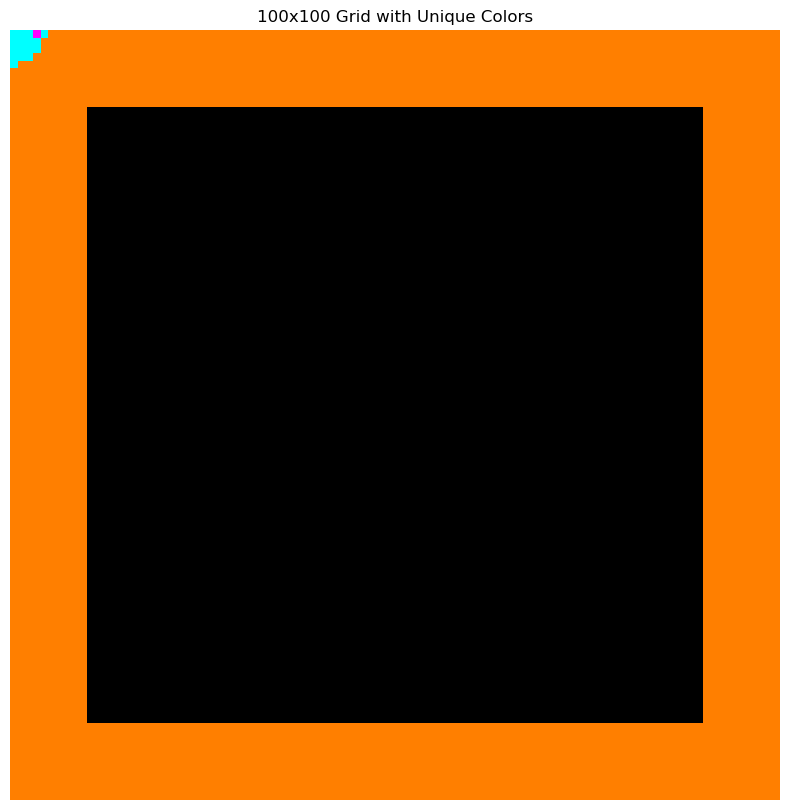

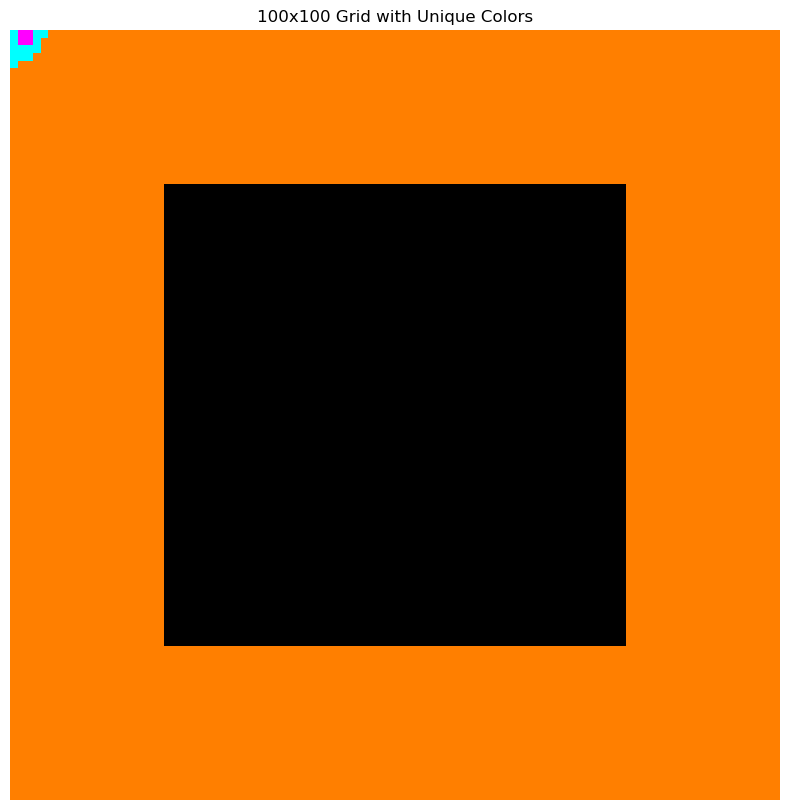

In [283]:
import numpy as np
import matplotlib.pyplot as plt

# Function to visualize the grid with unique colors
def plot_colored_grid(env_grid):
    # Define the possible values and their corresponding colors
    possible_values = [-1, -2, 100, 101, 102, 103, 104, 105, 0, 1, 2, 3]
    colors = [
        (0.0, 0.0, 0.0),   # Black for -1
        (0.5, 0.5, 0.5),   # Gray for -2
        (1.0, 0.0, 0.0),   # Red for 100
        (0.0, 1.0, 0.0),   # Green for 101
        (0.0, 0.0, 1.0),   # Blue for 102
        (1.0, 1.0, 0.0),   # Yellow for 103
        (1.0, 0.0, 1.0),   # Magenta for 104
        (0.0, 1.0, 1.0),   # Cyan for 105
        (1.0, 0.5, 0.0),   # Orange for 0
        (0.5, 0.5, 0.0),   # Olive for 1
        (0.5, 0.0, 0.5),   # Purple for 2
        (0.5, 0.5, 0.5),   # Dark Gray for 3
    ]

    # Create a color map
    color_map = {value: color for value, color in zip(possible_values, colors)}
    colored_grid = np.zeros((env_grid.shape[0], env_grid.shape[1], 3))


    # Fill the colored_grid with corresponding colors
    for value, color in color_map.items():
        colored_grid[env_grid == value] = color

    plt.figure(figsize=(10, 10))
    plt.imshow(colored_grid)
    plt.axis('off')  # Hide the axes
    plt.title("100x100 Grid with Unique Colors")
    plt.show()

# Call the function to plot the grid
plot_colored_grid(env.grid)
plot_colored_grid(eval_env.grid)